In [1]:
%pip install imbalanced-learn
%pip install xgboost
%pip install shap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import seaborn as sns
import shap

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, recall_score, precision_score, f1_score, average_precision_score, precision_recall_curve, make_scorer, auc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline

Note: you may need to restart the kernel to use updated packages.




c:\Desktop\coding\MYDAC-Curriculum\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('../datasets/data.csv')

In [3]:
# --------------------------- Feature Engineering -------------------------------

df.columns = df.columns.str.strip() #some columns have leading spaces


# Financial ratios being combined to see overall financial health of a company
df['Leverage_Index'] = df['Debt ratio %'] * df['Interest Expense Ratio']
df['Liquidity_Score'] = (df['Quick Ratio'] + df['Current Ratio'] + df['Cash/Total Assets']) / 3
df['Profitability_Index'] = (df['Operating Profit Rate'] + df['Net Income to Stockholder\'s Equity']) / 2
df['Cash Flow Growth Rate'] = df['Cash flow rate'].pct_change() * 100
df['Growth_Index'] = (df['Operating Profit Growth Rate'] + df['After-tax Net Profit Growth Rate'] + df['Cash Flow Growth Rate']) / 3


# Time-series features ie lagged features
df['Cash_Flow_Rate_3mo'] = df['Cash flow rate'].rolling(window=3).mean() #creating rolling averages
df['Total_Assets_Change_3mo'] = df['Cash/Total Assets'].pct_change(periods=3) * 100 #creating percent change in total assets


# Financial health indicators
df['Operating_Efficiency_Score'] = (df['Total Asset Turnover'] + df['Accounts Receivable Turnover'] + df['Inventory Turnover Rate (times)']) / (3 + 1e-6) #to prevent zero division error cos some columns may be zero value
df['Capital_Structure_Index'] = (df['Net worth/Assets'] + df['Equity to Long-term Liability']) / 2
df['Risk_Score'] = (df['Interest Coverage Ratio (Interest expense to EBIT)'] + df['Degree of Financial Leverage (DFL)']) / 2


# Categorical features
df['Risk_Flag'] = df['Net Income Flag'] * df['Liability-Assets Flag'] * df['Cash Flow to Liability']


# Interaction terms
df['Debt_CashFlow_Interaction'] = df['Debt ratio %'] * df['Cash Flow to Liability'] #debt-cash flow interaction
df['Profitability_Liquidity_Interaction'] = df['Operating Profit Rate'] * df['Quick Ratio']


#Correlation checking
corr_matrix = df.corr()
print(corr_matrix)

                                                    Bankrupt?  \
Bankrupt?                                            1.000000   
ROA(C) before interest and depreciation before ...  -0.260807   
ROA(A) before interest and % after tax              -0.282941   
ROA(B) before interest and depreciation after tax   -0.273051   
Operating Gross Margin                              -0.100043   
...                                                       ...   
Capital_Structure_Index                             -0.204602   
Risk_Score                                           0.004445   
Risk_Flag                                            0.138873   
Debt_CashFlow_Interaction                            0.247311   
Profitability_Liquidity_Interaction                  0.025037   

                                                    ROA(C) before interest and depreciation before interest  \
Bankrupt?                                                                                   -0.260807       


Cross-Validation ROC-AUC Scores:
[0.99765553 0.99925218 0.99910009 0.99880706 0.99923783]
Mean ROC-AUC: 0.9988
Standard Deviation: 0.0006
Validation Set Evaluation:

Validation Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1320
           1       0.97      1.00      0.98      1320

    accuracy                           0.98      2640
   macro avg       0.98      0.98      0.98      2640
weighted avg       0.98      0.98      0.98      2640


Validation Confusion Matrix:


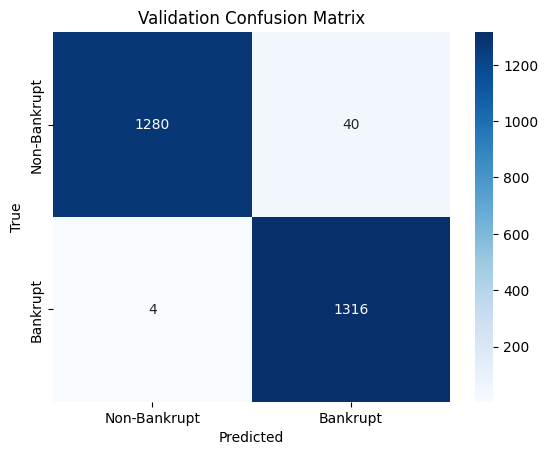

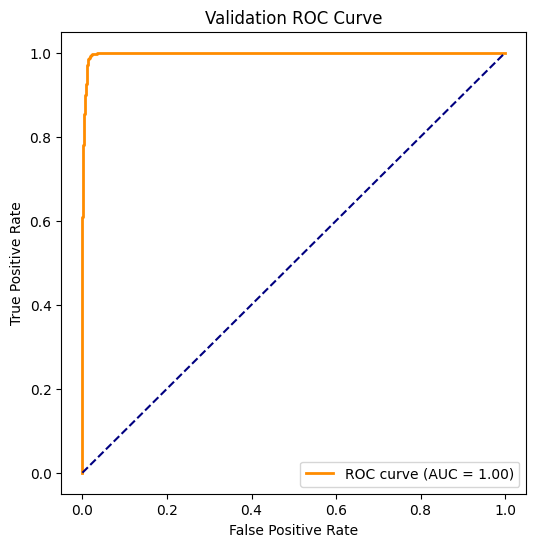

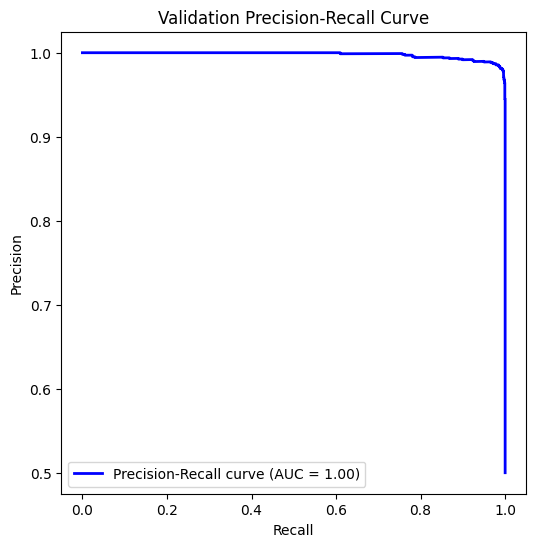


Test Set Evaluation:

Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      1320
           1       0.98      1.00      0.99      1320

    accuracy                           0.99      2640
   macro avg       0.99      0.99      0.99      2640
weighted avg       0.99      0.99      0.99      2640


Test Confusion Matrix:


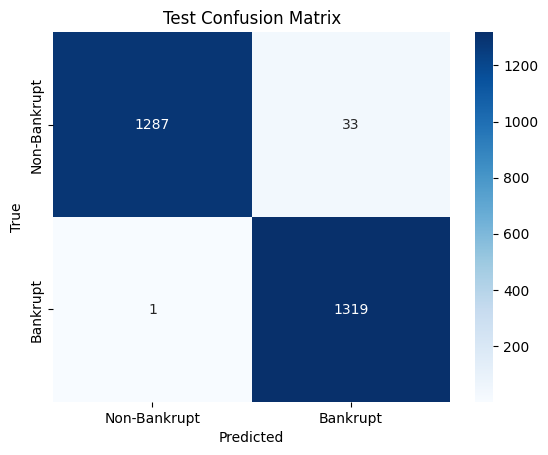

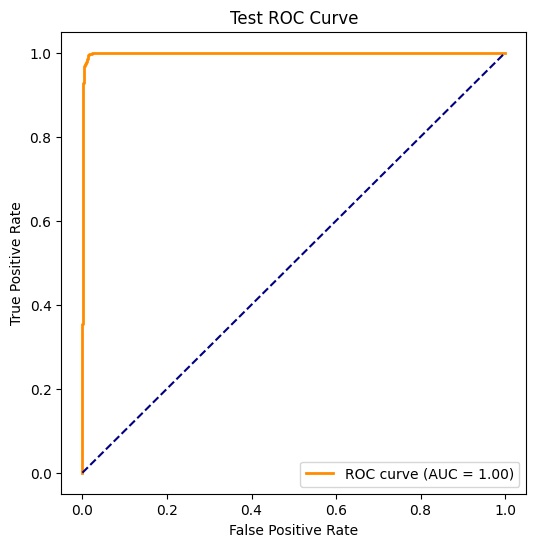

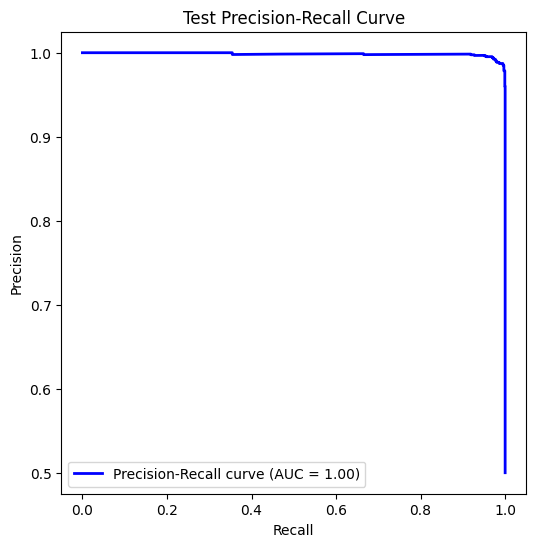

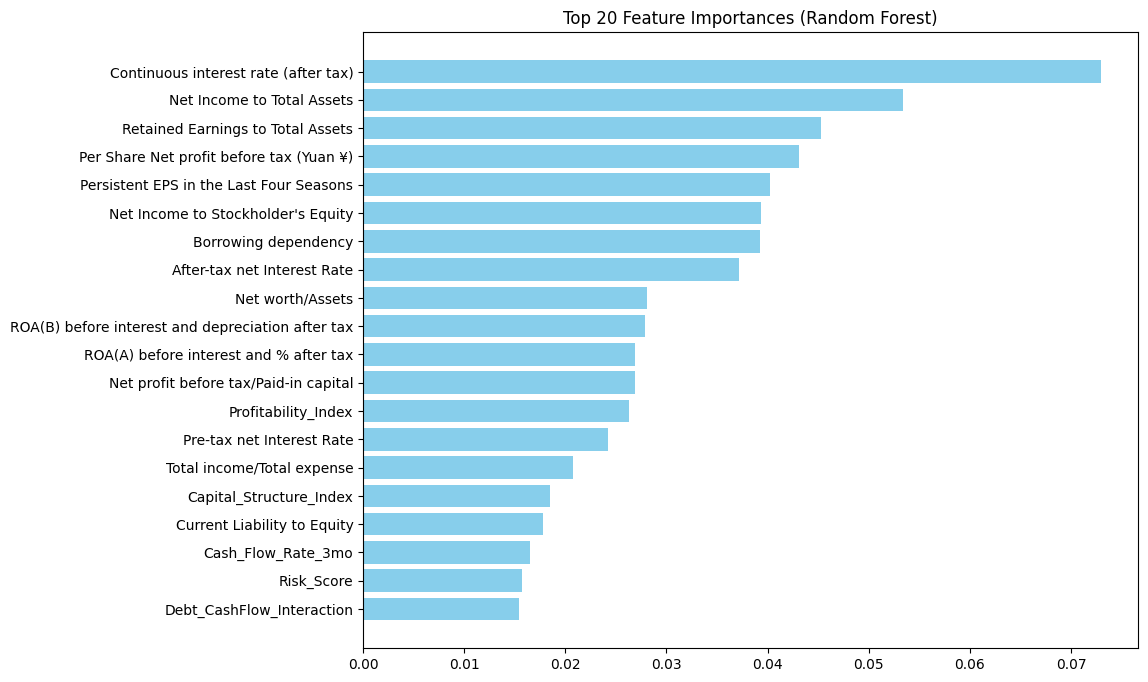

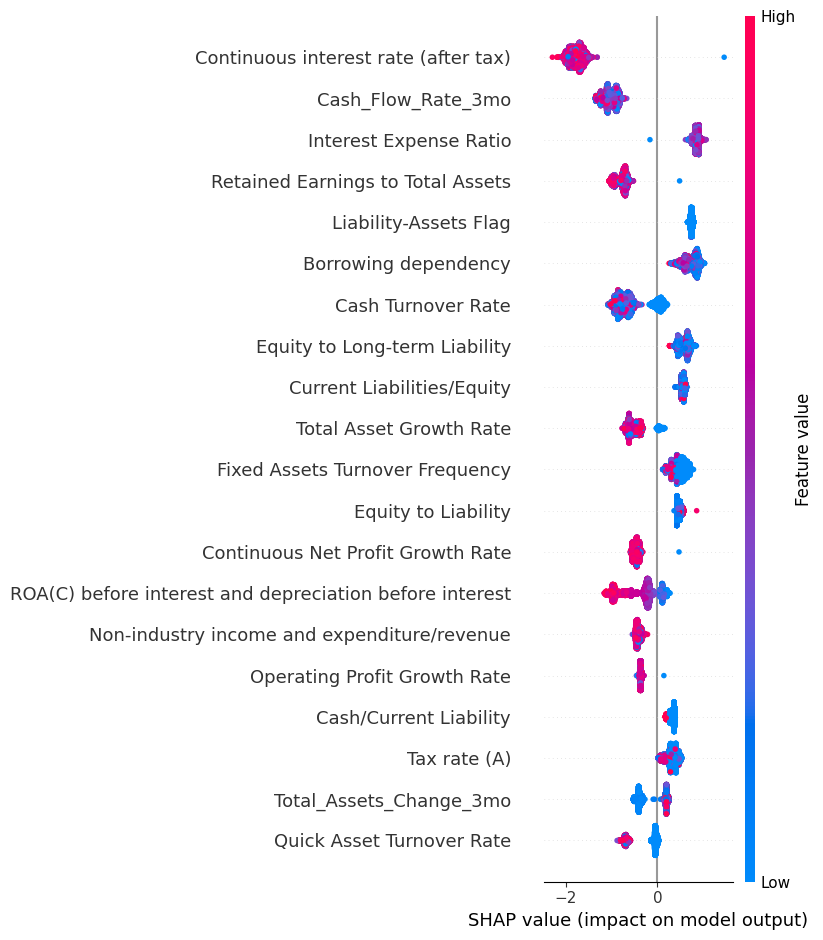

In [4]:
def evaluate_model(pipeline, X, y, dataset_name="Dataset"):
    """
    Evaluate a trained pipeline on a dataset and display performance metrics.
    Outputs classification report, confusion matrix, and ROC-AUC/PR curves.
    """
    y_pred = pipeline.predict(X)
    y_proba = pipeline.predict_proba(X)[:, 1]
    
    # Classification Report
    print(f"\n{dataset_name} Classification Report:")
    print(classification_report(y, y_pred))
    
    # Confusion Matrix
    print(f"\n{dataset_name} Confusion Matrix:")
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-Bankrupt', 'Bankrupt'], 
                yticklabels=['Non-Bankrupt', 'Bankrupt'])
    plt.title(f'{dataset_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    return plot_metrics(y, y_proba, dataset_name)

def plot_metrics(y, y_proba, dataset_name="Dataset"):
    """Plots ROC and Precision-Recall curves."""
    # ROC Curve
    fpr, tpr, _ = roc_curve(y, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.title(f'{dataset_name} ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y, y_proba)
    pr_auc = auc(recall, precision)
    plt.figure(figsize=(6, 6))
    plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
    plt.title(f'{dataset_name} Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='lower left')
    plt.show()

    return {"roc_auc": roc_auc, "pr_auc": pr_auc}


# ------------------- Preparing the data --------------------
# Features and target
X = df.drop('Bankrupt?', axis=1)
y = df['Bankrupt?']

# Handle missing values
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X[X.abs() > 1e10] = np.nan  # Combine extreme outlier handling
X_imputed = SimpleImputer(strategy='median').fit_transform(X)

# SMOTE for oversampling
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_imputed, y)

# Split into training, validation, and test sets
x_temp, x_val, y_temp, y_val = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)
x_train, x_test, y_train, y_test = train_test_split(x_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)




# ------------------- Creating the models --------------------
rf_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)
voting_model = VotingClassifier(estimators=[('rf', rf_model), ('xgb', xgb_model)], voting='soft')

pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('voting_model', voting_model)
])

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate pipeline using cross-validation
cv_scores = cross_val_score(pipeline, X_res, y_res, scoring='roc_auc', cv=cv, n_jobs=-1)
print("\nCross-Validation ROC-AUC Scores:")
print(cv_scores)
print(f"Mean ROC-AUC: {np.mean(cv_scores):.4f}")
print(f"Standard Deviation: {np.std(cv_scores):.4f}")


# ------------------- Training + Evaluation of (1) Validation and (2) Test Sets --------------------
pipeline.fit(x_train, y_train)  # Retrain on full training set for final evaluation


# Validation set evaluation
print("Validation Set Evaluation:")
validation_metrics = evaluate_model(pipeline, x_val, y_val, dataset_name="Validation")
# Test set evaluation
print("\nTest Set Evaluation:")
test_metrics = evaluate_model(pipeline, x_test, y_test, dataset_name="Test")


# ------------------- Feature Importance + SHAP Analysis --------------------
rf_model = pipeline.named_steps['voting_model'].named_estimators_['rf']
feat_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feat_importance_df['Feature'][:20], feat_importance_df['Importance'][:20], color='skyblue')
plt.title('Top 20 Feature Importances (Random Forest)')
plt.gca().invert_yaxis()
plt.show()

# --- SHAP for XGBoost ---
xgb_model = pipeline.named_steps['voting_model'].named_estimators_['xgb']
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(x_train)
shap.summary_plot(shap_values, x_train, feature_names=X.columns)

# Process Explanation

#### 1. Preparing the data
First, I replaced extreme values with NaN and filled any missing values with a median via the __SimpleImputer__. Then I used SMOTE to handle the class imbalance (more non-bankrupt companies than bankrupt) so that we create synthetic examples for the minority class -> creating a balanced dataset. Lastly, the data is split into training, validation and test sets via __train_test_split__ so that we can confirm the model generalises well to new unseen data --> reducing chances of overfitting.

#### 2. Creating model and cross-validation
The two models selected are RandomForest and XGBoost, which is then combined with a __Voting Classifier__. These models are chosen as RF is good for classification tasks and XGB is good at handling imbalanced datasets so that we can improve accuracy. The voting='soft' argument ensures that the classifier predicts based on predicted probabilites (ie. averaging prob from both models) instead of just the majority class voting.

After that, cross-validation is performed with 5 splits via  __StratifiedKFold__. The model is evaluated on each fold, and the average ROC-AUC score is calculated. Cross-validation allows us to evaluate how well the model performs on different subsets of the data, giving a more reliable estimate of its performance. Note: ROC-AUC score measures the model's ability to distinguish between the two classes (bankrupt vs. non-bankrupt) ; so higher is better.

Results of cross-validation show the __mean ROC-AUC__ which gives an overall of how well model distinguishes between the classes across all folds. (Closer to 1 is better) The standard deviation tells us about the variability in model performance across the folds. A lower standard deviation means the model performs consistently across different data splits. (Lower means more consistent across different data splits.)

#### 3. Evaluating model on validation and test sets
After we finished training the model on the training data, we evaluate performance on validation set and test set via the __evaluate_model__ function. This function is defined at the start to include:
- classification report: shows detailed view of ml performance wrt precision (how many predictions were correct), recall(how many true bankruptcies were identified)
- confusion matrix: helps us identify is modeel is making too many false positives/negatives
- roc curve: shows how well model distinguishes bw both classes at diff thresholds. So higher AUC is better.
- precision-recall curve: shows performance of minority class.


#### 4. Feature importance & SHAP
Feature importance is extracted from the Random Forest model inside the voting classifier. This shows which features are most influential in making predictions. So we can identify which factors are potentially key drivers of bankruptcy.

SHAP values are calculated for the XGBoost model within the voting classifier to explain the impact of each feature on the model’s predictions. 